<a href="https://colab.research.google.com/github/RafaSFernandes/DS_Projects/blob/main/Desafio06_Regress%C3%A3o_Aplicada_%C3%A0_Engenharia_de_Materiais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Escola DNC

Desafio prático

Matéria 9: Modelos de Classificação e Regressão

Regressão Aplicada à Engenharia de Materiais

Estudante: Rafael Souza Fernandes

#0. Recursos iniciais


##0.1. Bibliotecas

In [1077]:
#Montagem da pasta do Google Drive
from google.colab import drive

#Dados
import pandas as pd

#Matemática
import numpy as np

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#SKLEARN

#Modelos de regressão
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Separação de treino e teste
from sklearn.model_selection import train_test_split

#Métricas de avaliação
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error


# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #Métricas
# from sklearn.metrics import confusion_matrix #Matriz de confusão
# from sklearn.metrics import classification_report #Relatório com métricas de avaliação

##0.2. Funções

In [1078]:
#função para substituir espaços em branco por underline

def rename_columns(data_frame):                            #define a função passando um data_frame como parâmetro
  for name in data_frame.columns.values:                   #iteração para cada nome de coluna (noma da coluna representada por "name")
    for split in name.split():                             #iteração para cada plavra que compõe um nome (palavra representada por "split")
      if split == name.split()[0]:                         #se for a primeira palavra
        rename = split                                     #define a primeira palavra de rename ("rename" gera como resultado o novo nome da coluna)
      else:                                                #caso contrário
        rename += "_" + split                              #concatena _ com a próxima palavra
    data_frame = data_frame.rename(columns={name:rename})  #atualiza o nome desta coluna
  return data_frame                                        #retorna um data_frame com as colunas renomeadas

In [1079]:
#função plot do gráfico heatmap

def plot_heatmap(corr, size=6):
  fig = plt.subplots(figsize=(size, size))                        #definição de subplots com ajuste de tamanho da figura
  sns.heatmap(corr, cmap="Blues", annot=True)              #criando o heatmap da tabela de correlações
  plt.show()                                               #exibe o gráfico

In [1080]:
#função plot do gráfico de dispersão

# parâmetros = {
#     x_col: variável do eixo x,
#     y_col: variável do eixo y,
#     figsize: tamanho da figura do plot (mesmo figsize definido em plt.subplots),
#     x_step: passo de valores representados no eixo x (rótulos dos valores no eixo x)
#     y_step: passo de valores representados no eixo y (rótulos dos valores no eixo y)
#     guess_reg: palpite da reta de regressão (lista com duas listas, sendo a primeira os limites no eixo x e a segunda os limites do eixo y)
# }

def scatter_plot(x_col, y_col, figsize=(10, 10), x_step=10, y_step=10, guess_reg=[[0, 0],[0, 0]]):
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')     #definindo tamanho da figura
  sns.scatterplot(df, x=x_col, y=y_col)                             #definindo o gráfico de dispersão e as variáveis em seus eixos

  #limites dos rótulos no eixo x do gráfico
  x_min = max(int(round(x_col.min(), -1)) - 10, 0)    #menor valor positivo em x
  x_max = max(int(round(x_col.max(), -1)) + 10, 0)    #maior valor positivo em x

  #limites dos rótulos no eixo y do gráfico
  y_min = max(int(round(y_col.min(), -1)) - 10, 0)    #menor valor positivo em y
  y_max = max(int(round(y_col.max(), -1)) + 10, 0)    #maior valor positivo em y

  #rótulos dos eixos
  plt.xlabel(x_col.name)  #rótulo do eixo x
  plt.ylabel(y_col.name)  #rótulo do eixo y

  #rótulos dos valores no eixos
  plt.xticks(ticks=range(x_min, x_max, x_step)) #valores no no eixo x (menor valor, maior valor, passo/variação)
  plt.yticks(ticks=range(y_min, y_max, y_step)) #valores no no eixo y (menor valor, maior valor, passo/variação)

  #hipótese de regressão (palpite da reta de regressão)
  plt.plot(guess_reg[0], guess_reg[1], color="Red", linestyle="--")

  #título do gráfico
  plt.title(f"Dispersão: {x_col.name} x {y_col.name}")

  plt.show() #exibe apenas a figura

In [1081]:
#função para determinar os limites do intervalo interquartil
def limites_IQR(coluna):
  Q1 = coluna.quantile(0.25) #quartil 1
  Q3 = coluna.quantile(0.75) #quartil 3
  IQR = Q3 - Q1              #IQR
  LI = max(Q1 - 1.5*IQR, 0)  #limite inferior (não negativo, devido ao contexto dos dados)
  LS = Q3 + 1.5*IQR          #limite superior
  return LI, LS

In [1082]:
#report de métricas da regressão
def regression_report(y_true, y_pred):

  #cálculo de cada métrica
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  #armazenamento de cada métrica em um Series para report
  report = pd.Series(
      {
      "MAE": mae,
      "MSE": mse,
      "RMSE": rmse,
      "MAPE": mape,
      "R2": r2
  })

  return report

#1. Importando dados

In [1083]:
#montagem do Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1084]:
#caminho do arquivo csv
path = "/content/drive/MyDrive/Datasets_Modulos/Desafio_06/"

#nome do arquivo csv
filename = "dados_concreto - Sheet1.csv"

In [1085]:
#leitura dos dados
df = pd.read_csv(path + filename)

In [1086]:
#mantendo uma cópia original
df_zero = df

#2. Explorando os dados (EDA)

##2.1. Análise superficial

###2.1.1. Análise

In [1087]:
#verificando dimensões (linhas x colunas)
df.shape

(2029, 10)

In [1088]:
#nomes das colunas
df.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age',
       'Concrete compressive strength', 'Strength Category'],
      dtype='object')

In [1089]:
#renomeando colunas (substituindo espaços em branco por underline)
df = rename_columns(df)

In [1090]:
# verificando primeiras linhas
df.head()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Strength_Category
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99,Alto
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89,Alto
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27,Baixa
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05,Baixa
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30,Baixa


In [1091]:
#confirmando a presença de pelo menos um valor não inteiro em cada coluna (exceto as duas últimas)
(df.drop(columns=["Concrete_compressive_strength", "Strength_Category"]) - df.drop(columns=["Concrete_compressive_strength", "Strength_Category"]).astype(int) != 0).any()

,0
Cement,True
Blast_Furnace_Slag,True
Fly_Ash,True
Water,True
Superplasticizer,True
Coarse_Aggregate,True
Fine_Aggregate,True
Age,True


In [1092]:
# verificando tipos de dados
df.dtypes

,0
Cement,float64
Blast_Furnace_Slag,float64
Fly_Ash,float64
Water,float64
Superplasticizer,float64
Coarse_Aggregate,float64
Fine_Aggregate,float64
Age,float64
Concrete_compressive_strength,float64
Strength_Category,object


###2.1.2. Observações:

*   Base de dados com 2029 linhas e 10 colunas.
*   10 colunas com nomes separados por espaços. Foi criada uma função para substituir espaços em branco por *underline*. Já foi aplicada nesta etapa de exploração dos dados.
*   Analisando a descrição do problema e a base de dados, podemos já considerar a coluna "Concrete_compressive_strength" como a variável dependente, ou seja, variável "target".
*   Excluindo-se as duas últimas colunas, todas apresentam pelo menos um valor não inteiro.
*   As colunas não possuem unidades de medida .
*   A única coluna do tipo "object" é a última, sendo uma coluna categórica. As demais colunas são do tipo "float64", consideradas colunas numéricas de valores não negativos.
*   Os dados não estão normalizados.

##2.2. Identificando dados para o tratamento

###2.2.1. Identificação

In [1093]:
#verificação da presença de algum dado nulo
df.isnull().any()

,0
Cement,False
Blast_Furnace_Slag,False
Fly_Ash,False
Water,False
Superplasticizer,False
Coarse_Aggregate,False
Fine_Aggregate,False
Age,False
Concrete_compressive_strength,True
Strength_Category,False


In [1094]:
#contagem de valores nulos na coluna "Concrete compressive strength"
df["Concrete_compressive_strength"].isnull().sum()

np.int64(9)

In [1095]:
#verificando as linhas com dados nulos na coluna "Concrete compressive strength"
df[df["Concrete_compressive_strength"].isnull() == True]

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Strength_Category
1693,359.1,560.0,0.0,249.6,0.0,1483.8,1594.5,44.8,NaN,Baixa
1761,418.8,0.0,0.0,460.8,0.0,2006.4,1375.3,6.6,NaN,Baixa
1762,663.1,0.0,0.0,460.8,0.0,1267.2,1618.0,13.3,NaN,Baixa
1823,483.2,0.0,0.0,345.1,0.0,1363.6,980.4,36.4,NaN,Baixa
1994,201.2,459.5,159.1,249.1,22.1,2279.5,1288.5,30.8,NaN,Baixa
1998,229.0,0.0,447.4,450.5,20.0,1922.0,965.9,70.0,NaN,Baixa
2011,363.5,0.0,500.9,221.9,17.9,1812.8,1042.4,50.4,NaN,Baixa
2020,334.0,195.9,194.2,435.5,32.9,2171.2,1041.9,44.8,NaN,Baixa
2025,428.2,387.1,301.6,402.7,27.0,1525.3,1439.4,47.6,NaN,Baixa


In [1096]:
#guardando dados nulos para prever após ter o modelos de regressão finalizado
df_to_predict = df[df["Concrete_compressive_strength"].isnull() == True]

In [1097]:
#contagem de valores duplicados
df.duplicated().sum()

np.int64(25)

In [1098]:
#verificando as linhas duplicadas
df[df.duplicated() == True].drop_duplicates()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Strength_Category
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3.0,33.40,Baixa
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3.0,35.30,Baixa
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7.0,49.20,Baixa
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7.0,55.90,Baixa
123,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28.0,60.29,Alto
132,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28.0,71.30,Alto
146,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56.0,64.30,Alto
155,362.6,189.0,0.0,164.9,11.6,944.7,755.8,56.0,77.30,Alto
169,425.0,106.3,0.0,153.5,16.5,852.1,887.1,91.0,65.20,Alto
177,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91.0,79.30,Alto


In [1099]:
#contagem de linhas únicas
df[df.duplicated() == True].drop_duplicates().shape

(11, 10)

In [1100]:
#separação de colunas numéricas de categóricas
df_numeric = df.drop(columns="Strength_Category")
df_categoric = df["Strength_Category"]

In [1101]:
#contagem de valores distintos na coluna categórica
df_categoric.nunique()

2

In [1102]:
#verificando os valores distintos na coluna categórica
df_categoric.unique()

array(['Alto', 'Baixa'], dtype=object)

In [1103]:
#verificando a distribuição de categorias
df_categoric.value_counts(normalize=True)

,proportion
Strength_Category,
Baixa,0.906851
Alto,0.093149


In [1104]:
#porcentagem de outliers por coluna
num_out = []  #contador de outliers por coluna
n_rows = df.shape[0]  #total de linhas do dataframe

for col in df_numeric.columns: #para cada coluna numérica
  LI, LS = limites_IQR(df[col]) #encontra os limites IQR da coluna
  num_out.append(df[(df[col] < LI) | (df[col] > LS)].shape[0]) #conta a quantidade de outliers da coluna

round(pd.DataFrame(num_out, index=df_numeric.columns, columns=["outliers_rate"])/n_rows * 100, 2).sort_values(by="outliers_rate", ascending=False)

,outliers_rate
Age,9.66
Cement,5.13
Blast_Furnace_Slag,3.10
Fly_Ash,2.71
Superplasticizer,2.07
Concrete_compressive_strength,0.54
Water,0.34
Fine_Aggregate,0.15
Coarse_Aggregate,0.00


In [1105]:
#define a quantidade de colunas numéricas (excluindo o target 'Concrete_compressive_strength')
n = len(df_numeric.columns) - 1

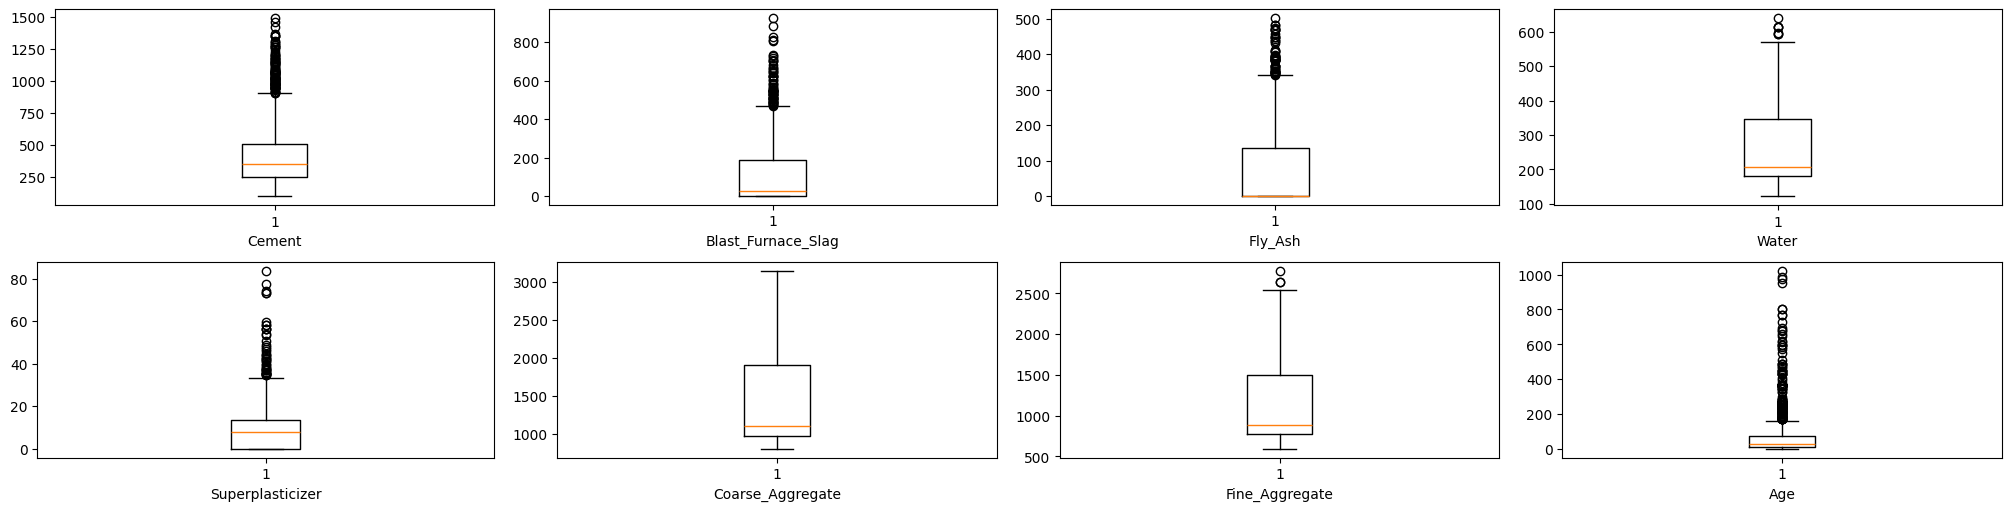

In [1106]:
#boxplot de cada coluna
fig = plt.figure(figsize=(20, 5), layout="constrained") #define a figura inteira
subfigs = fig.subfigures(2, 4) #define as subfigures (2 linhas e 4 colunas, totalizando 8)

for i in range(n): #para cada posição i da lista de colunas
  axs = subfigs[i//4, i%4].subplots() #posiciona o eixo na subfigure
  axs.boxplot(df[df.columns[i]])      #plota o boxplot da coluna i
  axs.set_xlabel(df.columns[i])       #rotula o plot

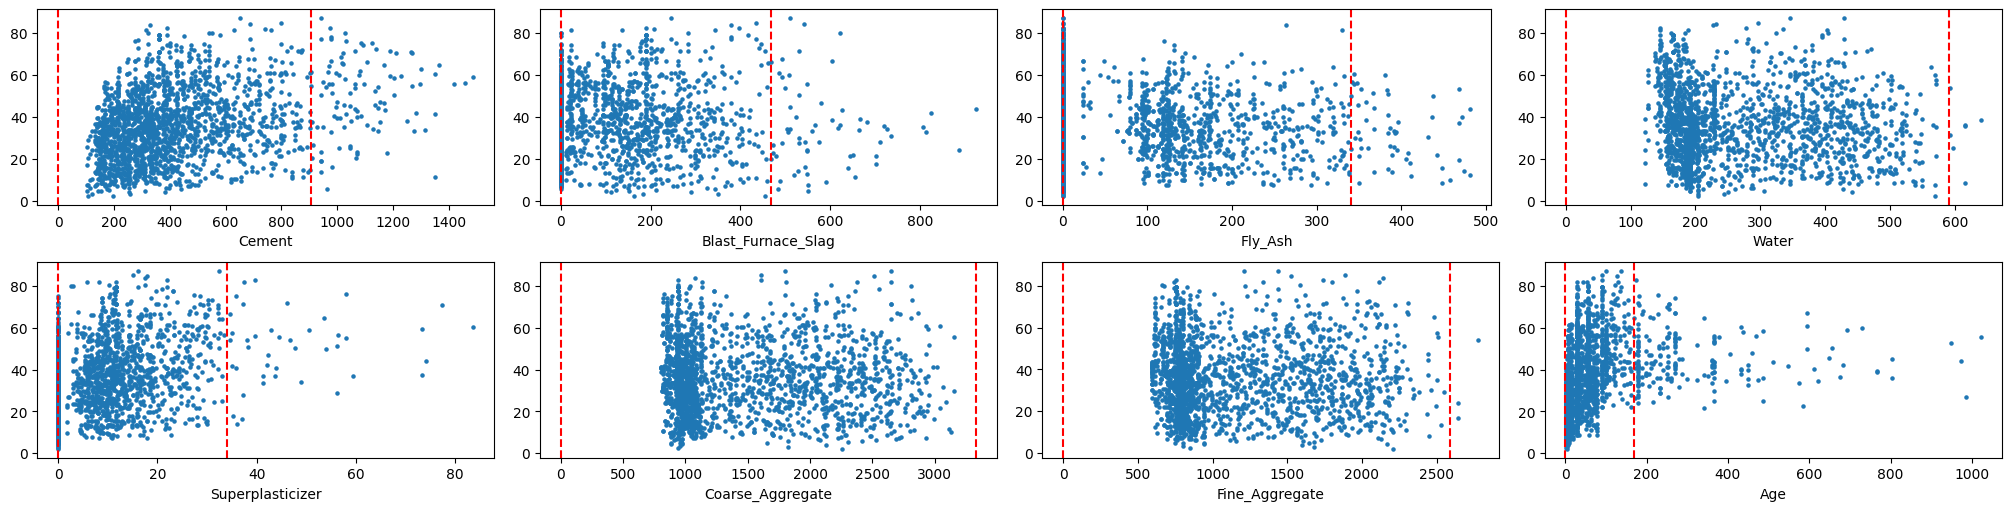

In [1107]:
#plot de dispersão de cada coluna por 'Concrete_compressive_strength'
fig = plt.figure(figsize=(20, 5), layout="constrained") #define a figura inteira
subfigs = fig.subfigures(2, 4) #define as subfigures (2 linhas e 4 colunas, totalizando 8)

for i in range(n): #para cada posição i da lista de colunas
  LI, LS = limites_IQR(df[df.columns[i]]) #determinar os limites IQR
  axs = subfigs[i//4, i%4].subplots()     #posiciona o eixo na subfigure
  axs.scatter(df[df.columns[i]], df['Concrete_compressive_strength'], s=5)  #plot de dispersão da coluna i

  #rotula o eixo x
  axs.set_xlabel(df.columns[i])

  #marca os limites IQR com linhas verticais
  axs.axvline(LI, color="Red", linestyle="--")
  axs.axvline(LS, color="Red", linestyle="--")

###2.2.2. Observações:

*   A única coluna com valores nulos é a coluna "Concrete_compressive_strength". Possui 9 valores nulos. Estão todos classificados com resistência de categoria "Baixa". Não podemos confirmar se esta categoria está correta para esse valores. Por serem poucos valores, serão descartados para análise.
*   Ao final, após obter os resultados de regressão, vamos retornar nestes dados nulos e avaliar como seriam classificados de acordo com a predição do modelo criado.
*   Existem 25 valores duplicados na base. Destes, 11 são únicos e os 14 restantes serão descartados. Para testar a resistência do concreto não precisamos de duas amostras iguais de confecção, portanto as repetições não são necessárias para análise.
*   A única coluna categórica é a "Strength_Category", sendo as demais todas numéricas.
*   Na categoria "Strength_Category" há apenas 2 categorias identificadas: "Alto" e "Baixa". Na descrição do problema há um terceiro valor ("Média") que não está presente na base de dados. Serão considerados apenas os dois valores que estão presentes na base de dados. Sendo assim, temos um output categórico binário.
*   A distribuição das categorias está bem desbalanceada, sendo 90% dos dados da categoria "Baixa".
*   A coluna com maior quantidade de outliers é a coluna "Age", com 196 valores, representando 9.66% do Data Frame.
*   Analisando o boxplot em conjunto com o gráfico de dispersão desta coluna, observa-se um padrão de crescimento de resistência do concreto no intervalo de 0 a 180 no eixo x. Após 180, não há muita diferença nessa resistência, mas ela se mantém acima de 20. Sendo assim, não há motivos em esperar mais tempo visando aumentar a resistência. Portanto, os outliers desta variável serão removidos.

##2.3. Identificando correlações

###2.3.1. Correlações

In [1108]:
#verificando correlações presentes nas colunas numéricas em ordem descrescente
corr = round(df_numeric.corr(), 2)
corr.sort_values(by="Concrete_compressive_strength", ascending=False)

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength
Concrete_compressive_strength,0.33,0.11,-0.09,-0.06,0.33,-0.02,-0.02,0.29,1.00
Cement,1.00,-0.03,-0.11,0.41,0.25,0.45,0.42,0.16,0.33
Superplasticizer,0.25,0.09,0.37,0.08,1.00,0.19,0.28,-0.10,0.33
Age,0.16,0.02,-0.07,0.23,-0.10,0.18,0.14,1.00,0.29
Blast_Furnace_Slag,-0.03,1.00,-0.24,0.21,0.09,0.18,0.12,0.02,0.11
Fine_Aggregate,0.42,0.12,0.19,0.53,0.28,0.58,1.00,0.14,-0.02
Coarse_Aggregate,0.45,0.18,0.16,0.60,0.19,1.00,0.58,0.18,-0.02
Water,0.41,0.21,0.11,1.00,0.08,0.60,0.53,0.23,-0.06
Fly_Ash,-0.11,-0.24,1.00,0.11,0.37,0.16,0.19,-0.07,-0.09


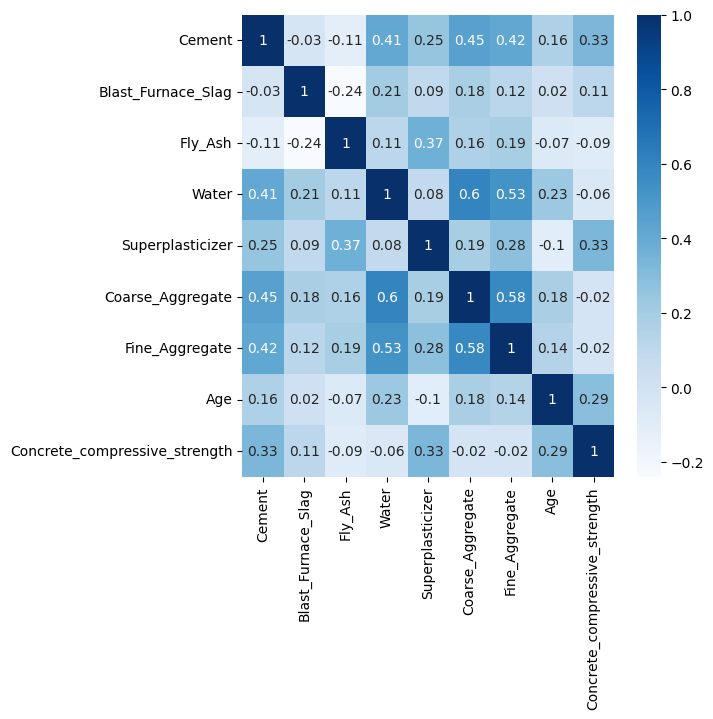

In [1109]:
#plot heatmap da tabela de correlações
plot_heatmap(corr)

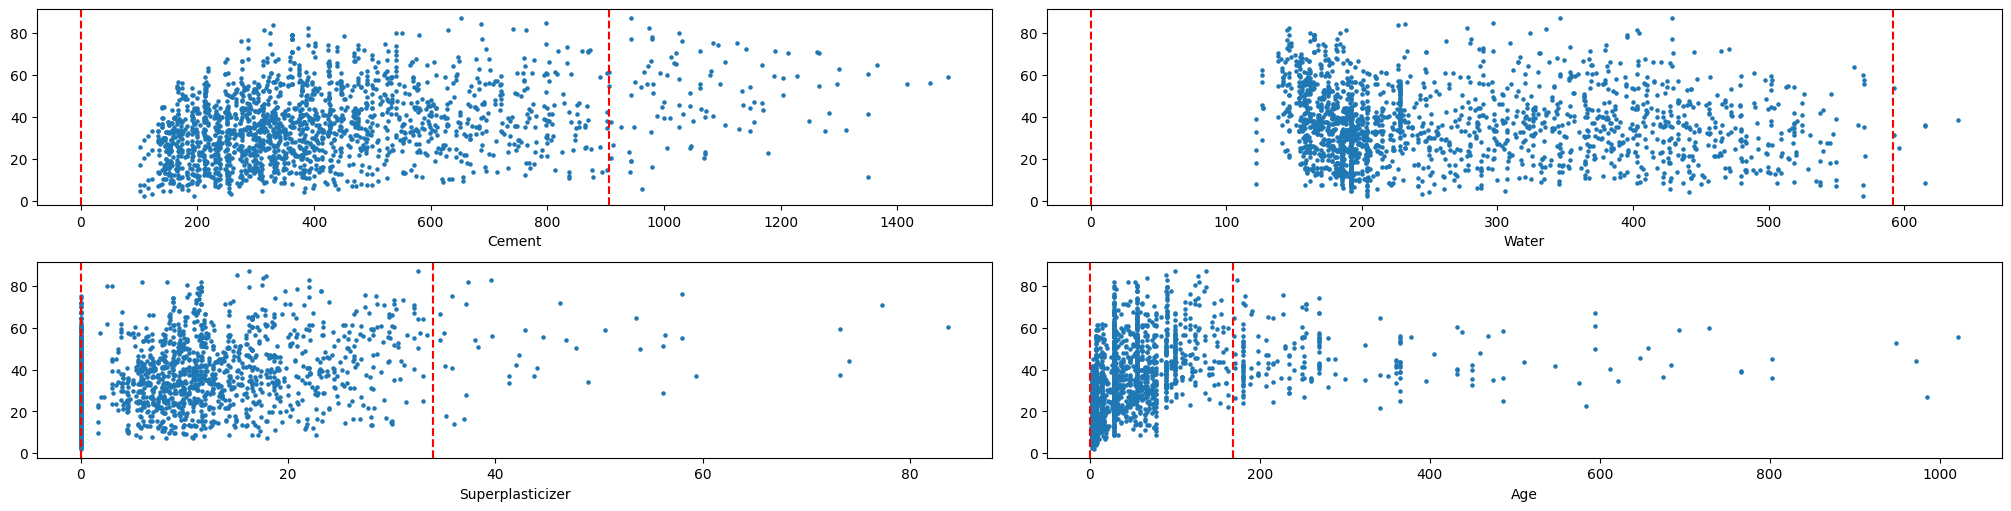

In [1110]:
#plot de dispersão de cada coluna por 'Concrete_compressive_strength'
fig = plt.figure(figsize=(20, 5), layout="constrained") #define a figura inteira
subfigs = fig.subfigures(2, 2) #define as subfigures (2 linhas e 4 colunas, totalizando 8)
columns = ["Cement", "Water", "Superplasticizer", "Age"]

for i in range(4): #para cada posição i da lista de colunas
  LI, LS = limites_IQR(df[columns[i]]) #determinar os limites IQR
  axs = subfigs[i//2, i%2].subplots()     #posiciona o eixo na subfigure
  axs.scatter(df[columns[i]], df['Concrete_compressive_strength'], s=5)  #plot de dispersão da coluna i

  #rotula o eixo x
  axs.set_xlabel(columns[i])

  #marca os limites IQR com linhas verticais
  axs.axvline(LI, color="Red", linestyle="--")
  axs.axvline(LS, color="Red", linestyle="--")

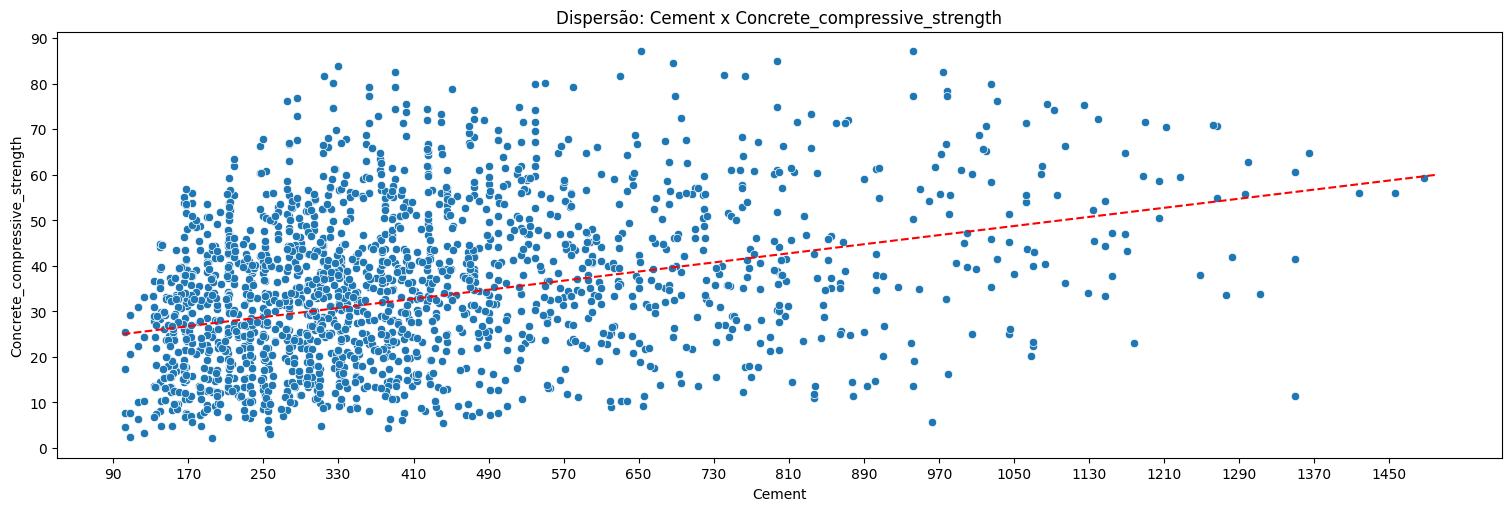

In [1111]:
#gráfico de dispersão entre "Cement" e "Concrete_compressive_strength"
scatter_plot(df["Cement"], df["Concrete_compressive_strength"], figsize=(15, 5), x_step=80, guess_reg=[[100, 1500],[25, 60]])

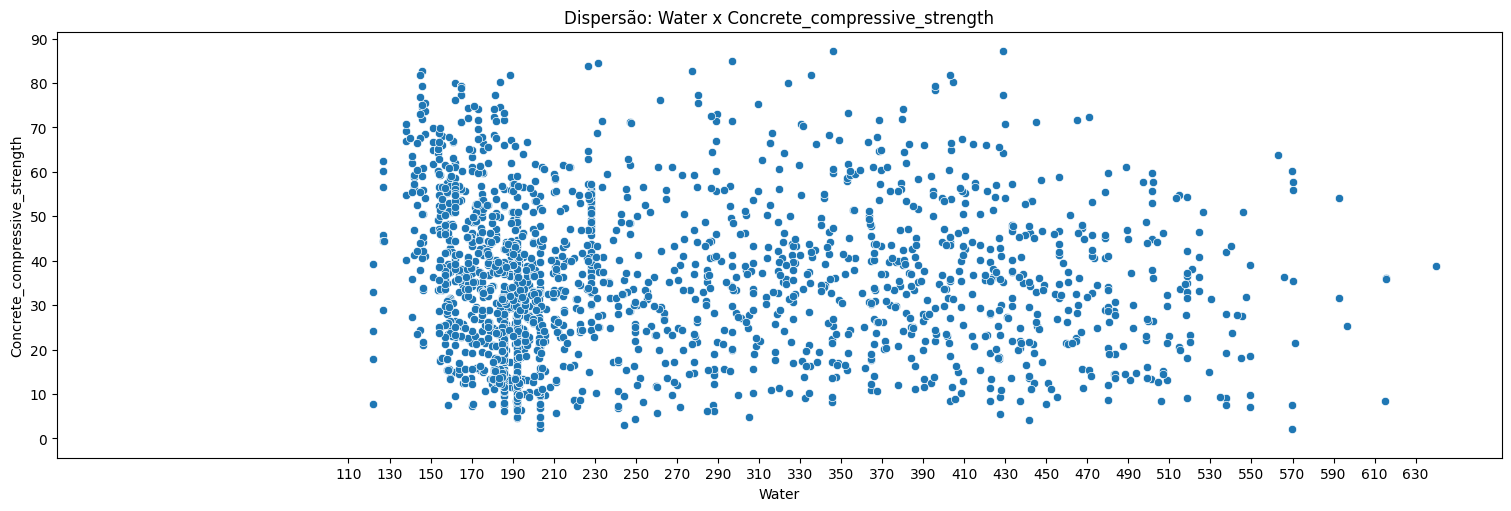

In [1112]:
#gráfico de dispersão entre "Water" e "Concrete_compressive_strength"
scatter_plot(df["Water"], df["Concrete_compressive_strength"], figsize=(15, 5), x_step=20)

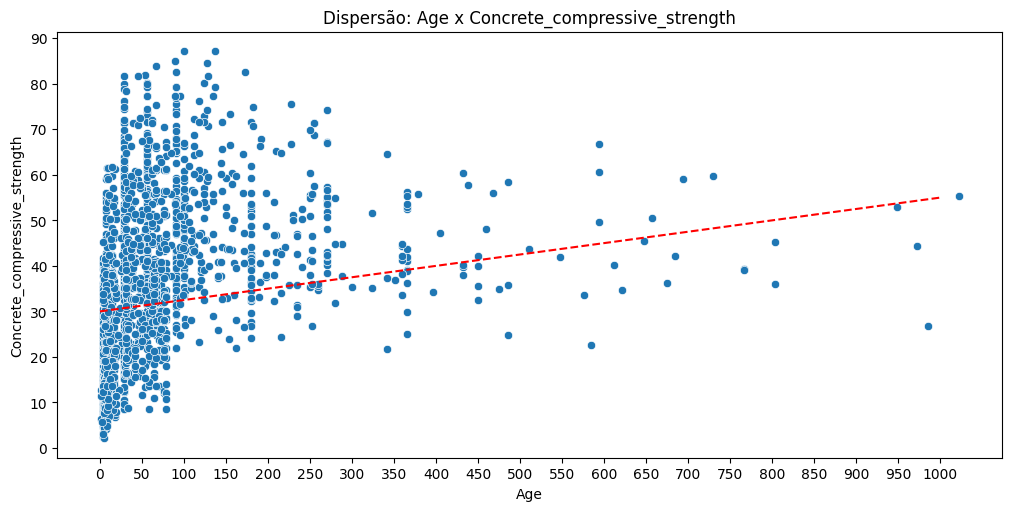

In [1113]:
#gráfico de dispersão entre "Age" e "Concrete_compressive_strength"
scatter_plot(df["Age"], df["Concrete_compressive_strength"], figsize=(10,5), x_step=50, guess_reg=[[0, 1000],[30, 55]])

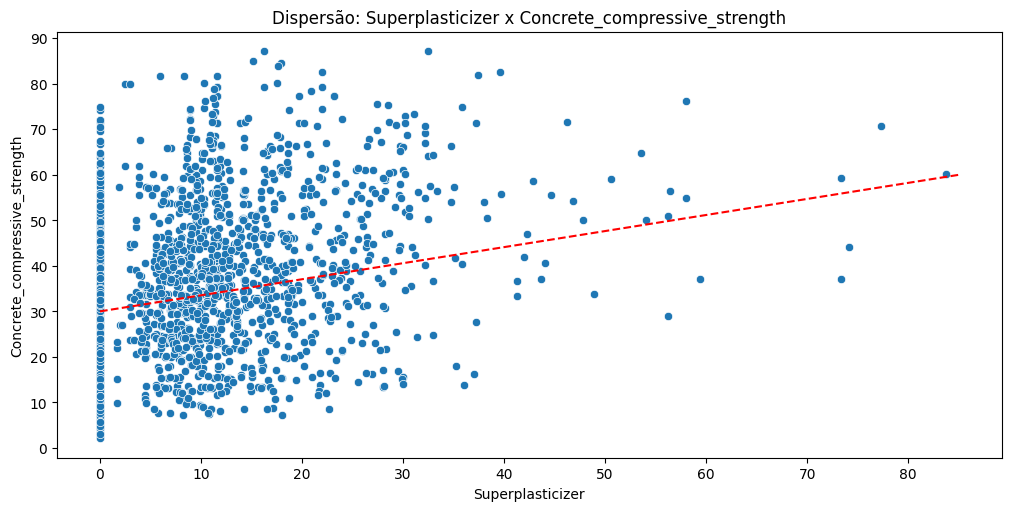

In [1114]:
#gráfico de dispersão entre "Superplasticizer" e "Concrete_compressive_strength"
scatter_plot(df["Superplasticizer"], df["Concrete_compressive_strength"], figsize=(10,5), x_step=10, guess_reg=[[0, 85], [30, 60]])

In [1115]:
#calculando a média de resistência do concreto para cada categoria
df_category_mean = df.groupby(by="Strength_Category").agg("mean")["Concrete_compressive_strength"]
df_category_mean

,Concrete_compressive_strength
Strength_Category,
Alto,68.810265
Baixa,32.488236


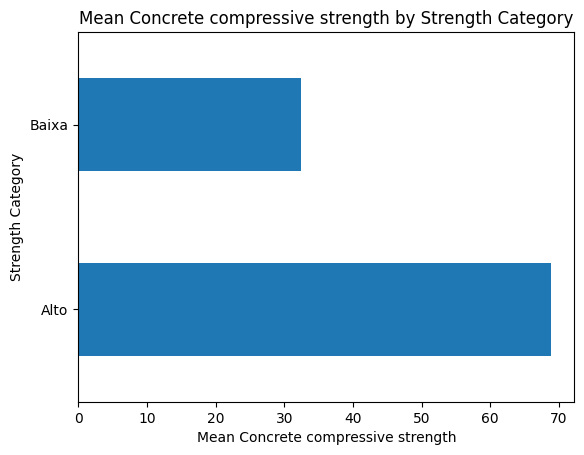

In [1116]:
df_category_mean.plot(kind="barh") #criando o gráfico de barras horizontais

#rótulos dos eixos
plt.xlabel("Mean Concrete compressive strength")
plt.ylabel("Strength Category")

#título do gráfico
plt.title("Mean Concrete compressive strength by Strength Category")

plt.show() #exibe apenas a figura

In [1117]:
#menor valor da categoria "Alto"
alto_min = df[df['Strength_Category'] == "Alto"]['Concrete_compressive_strength'].min()

#maior valor da categoria "Baixa"
baixo_max = df[df['Strength_Category'] == "Baixa"]['Concrete_compressive_strength'].max()

###2.3.2. Observações:

*   As variáveis com correlação mais significativa com a resistência do concreto (Concrete_compressive_strength) são: Cement, Superplasticizer e Age. Estas correlações são positivas, o que indica que o aumento de uma variável está correlacionada ao aumento da resistência do concreto.
*   A água (Water) não possui correlação significativa.
*   A reta tracejada em vermelho é uma tentativa de uma aproximação à reta de regressão a partir de uma análise visual da dispersão. É um palpite do resultado final, sem considerar cálculo algum.
*   A resistência média da categoria "Alto" é de 68.810265, enquanto da categoria "Baixa" é de 32.488236.
*   Dados os valores mínimo e máximo das respectivas categorias "Alto" e "Baixo", podemos tomar o valor 60 como referência para categorizar. Neste caso, assumiremos valores iguais ou superior a 60 como concretos da categoria de resistência alta.

#3. Tratamento dos dados

##3.1. Nulos

In [1118]:
#removendo valores nulos e atualizando o dataframe
df = df.dropna()

##3.2. Duplicatas

In [1119]:
#removendo valores duplicados e atualizando o dataframe
df = df.drop_duplicates()

##3.3. Variáveis categóricas

In [1120]:
#atualizando variáveis numéricas e categóricas
df_numeric = df.drop(columns="Strength_Category")
df_categoric = df["Strength_Category"]

In [1121]:
#organizando dummies
df_cat_dummies = pd.get_dummies(df_categoric, dtype=int, drop_first=True)

In [1122]:
#concatenando dummies ao dataframe
df = pd.concat([df.drop(columns="Strength_Category"), df_cat_dummies], axis=1)

In [1123]:
#renomeando a coluna "Baixo" para "Low_Strength"
df = df.rename(columns={"Baixa": "Low_Strength"})

##3.4. Outliers

###3.4.1. Tratamento

In [1124]:
#recalculando correlações após dummies
corr = round(df.corr(), 2)
corr['Concrete_compressive_strength'].sort_values(ascending=False)

,Concrete_compressive_strength
Concrete_compressive_strength,1.00
Cement,0.34
Superplasticizer,0.33
Age,0.30
Blast_Furnace_Slag,0.10
Coarse_Aggregate,-0.00
Fine_Aggregate,-0.00
Water,-0.04
Fly_Ash,-0.08
Low_Strength,-0.61


In [1125]:
#removendo outliers
LI, LS = limites_IQR(df["Age"]) #identifica os limites IQR
df = df[(df["Age"] < LI) | (df["Age"] > LS) == False] #filtra os dados que não são outliers e atualiza o dataframe

In [1126]:
#dataframe sem os outliers da coluna "Age"
df

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Low_Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89,0
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90.0,47.03,1
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28.0,36.45,1
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85,1
...,...,...,...,...,...,...,...,...,...,...
2023,607.2,237.8,0.0,448.4,17.4,1701.5,1156.0,78.4,33.40,1
2024,449.2,0.0,0.0,323.3,17.4,2229.0,1314.7,30.8,39.10,1
2026,183.1,310.3,0.0,380.0,17.0,2604.7,1299.4,30.8,24.20,1
2027,651.0,399.8,0.0,386.2,19.0,2102.9,1125.6,72.8,40.80,1


In [1127]:
#recalculando correlações após remover outliers
corr_age_out = round(df.corr(), 2)  #atualiza correlações
gap = (corr_age_out-corr).rename(columns={"Concrete_compressive_strength":"Gap"})["Gap"] #calcula a diferença de correlações (gap)
pd.concat([corr_age_out['Concrete_compressive_strength'],gap], axis=1).sort_values(by="Concrete_compressive_strength", ascending=False) #verificando as mudanças nas correlações

,Concrete_compressive_strength,Gap
Concrete_compressive_strength,1.00,0.00
Age,0.49,0.19
Superplasticizer,0.36,0.03
Cement,0.32,-0.02
Blast_Furnace_Slag,0.10,0.00
Fine_Aggregate,-0.03,-0.03
Coarse_Aggregate,-0.04,-0.04
Fly_Ash,-0.07,0.01
Water,-0.08,-0.04
Low_Strength,-0.62,-0.01


###3.4.2. Observações

*   Como há apenas nulos na coluna Concrete_compressive_strength, basta o `dropna()` para removê-los. São apenas 9 linhas. Logo a base fica com 2020 linhas após o procedimento.
*   Como os dados duplicados não interferem na previsão de Concrete_compressive_strength, basta o `drop_duplicates()` para removê-los. São apenas 25 linhas. Logo a base fica com 1995 linhas após o procedimento.
*   Como a saída categórica é binária ("Alto" ou "Baixo"), não precisamos de todos os dummies, basta um apenas. Neste caso, com o parâmetro `drop_first=True`, teremos o valor 1 indicando a categoria "Baixa" e o valor zero  representando a categoria "Alto". Isto deve gerar uma correlação negativa em relação à resistência do concreto
*   Com a remoção de outliers da coluna "Age", o dataframe ficou com 1799 linhas.
*   Houve um aumento (esperado) de 19% na sua correlação com a resistência do concreto, sendo que as demais variáveis sofreram alterações menores que 5%.

#4. Modelagem

In [1128]:
#separação das variáveis
X = df.drop(columns=["Concrete_compressive_strength", "Low_Strength"])
y = df["Concrete_compressive_strength"]

##4.1. Random Forest Regressor (RFR)

In [1129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [1130]:
print(f"y_train: {y_train.size}\ny_test: {y_test.size}")

y_train: 1259
y_test: 540


In [1131]:
#criando o modelo
model_RFR = RandomForestRegressor(random_state=42)
model_RFR.fit(X_train, y_train) #treino

RandomForestRegressor(random_state=42)

In [1132]:
#prevendo valores
y_pred_RFR = model_RFR.predict(X_test)

In [1133]:
#cálculo de resíduos
residuals_RFR = y_test - y_pred_RFR
residuals_RFR.rename("RandomForestRegressor_Residuals", inplace=True)

,RandomForestRegressor_Residuals
1148,-7.91390
278,2.53770
1779,15.83280
496,5.04545
876,3.07160
...,...
738,4.03360
173,5.45270
1507,-4.45740
696,-4.31550


##4.2. Linear Regression (LR)

In [1134]:
#criando o modelo
model_LR = LinearRegression()
model_LR.fit(X_train, y_train) #treino

LinearRegression()

In [1135]:
#previsão
y_pred_LR = model_LR.predict(X_test)

In [1136]:
#cálculo de resíduos
residuals_LR = y_test - y_pred_LR
residuals_LR.rename("LinearRegression_Residuals", inplace=True)

,LinearRegression_Residuals
1148,-6.143868
278,-2.611059
1779,11.986001
496,17.308852
876,2.818048
...,...
738,-5.563970
173,11.586972
1507,-22.060521
696,-12.251865


##4.3. Comparando modelos

###4.3.1. Comparação

In [1137]:
#comparativo de métricas para cada modelo com arredondamento de 2 casas decimais
round(pd.concat([regression_report(y_test, y_pred_RFR), regression_report(y_test, y_pred_LR)], axis=1).rename(columns={0:"RFR", 1:"LR"}), 2)

,RFR,LR
MAE,6.07,9.11
MSE,70.31,134.18
RMSE,8.39,11.58
MAPE,0.23,0.38
R2,0.76,0.54


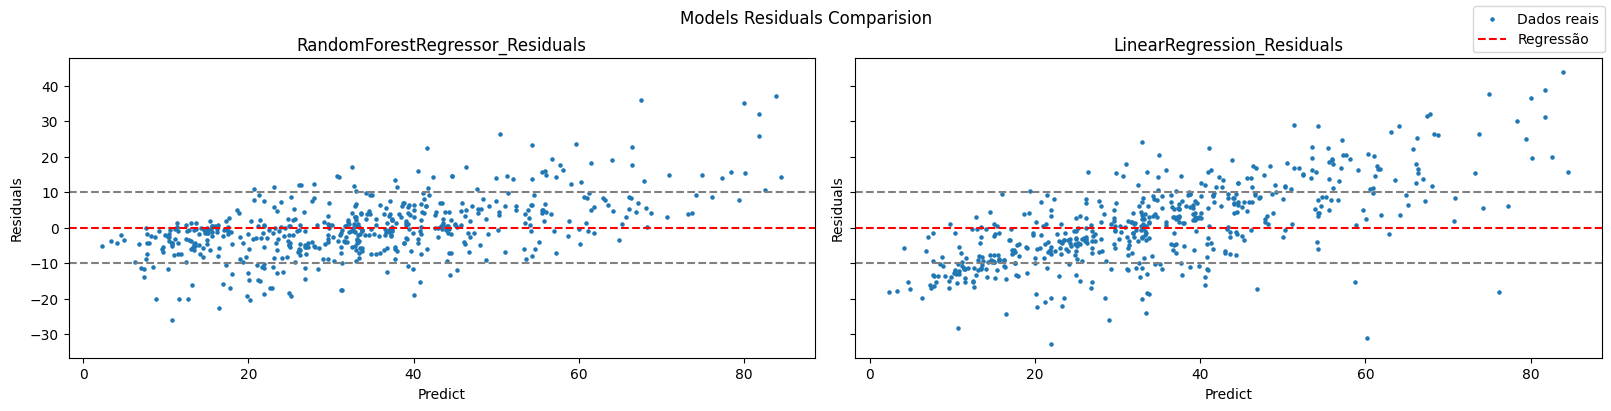

In [1138]:
residuals = [residuals_RFR, residuals_LR] #lista de residuos de cada modelo

#plot de dispersão de cada coluna por 'Concrete_compressive_strength'
fig = plt.figure(figsize=(16, 4), layout="constrained") #define a figura inteira
axs = fig.subplots(1, 2, sharey=True) #define os dois eixos com y compartilhado (para comparar os dois)

for i in range(2): #para cada posição i da lista de residuos
  axs[i].scatter(y_test, residuals[i], s=5)  #plot de dispersão dos residuos i

  #titulo do eixo
  axs[i].set_title(residuals[i].name)

  #rotula o eixo x
  axs[i].set_xlabel("Predict")
  axs[i].set_ylabel("Residuals")

  #linha de regressão
  axs[i].axhline(0, color="Red", linestyle="--", label="Regressão")

  #linhas auxiliares no intervalo (-10. 10), visando a aproximação de zero
  axs[i].axhline(-10, color="Gray", linestyle="--")
  axs[i].axhline(10, color="Gray", linestyle="--")

fig.suptitle("Models Residuals Comparision")

#legendas
fig.legend(labels=["Dados reais", "Regressão"])

#exibe o gráfico
plt.show()

In [1139]:
c = 10 #erro absoluto

for i in range(2): #para cada modelo
  #calcula o percentual de valores com erros menores que 10
  residual_per = residuals[i][(-c < residuals[i]) & (residuals[i] < c)].size / y_test.size
  print(residuals[i].name, round(residual_per, 2))

RandomForestRegressor_Residuals 0.82
LinearRegression_Residuals 0.64


### 4.3.2. Conclusões

*   O modelo RFR apresenta MAE inferior ao modelo LR, indicando erros absolutos menores. Da mesma forma observamos valores inferiores para as métricas alternativas MSE e RMSE.
*   O modelo RFR apresenta MAPE inferior ao modelo LR, apresentando menor taxa de erro na predição.
*   O modelo RFR apresenta R² superior ao modelo LR, apresentando maior qualidade nas predições.
*   No gráfico de dispersão comparativo, observamos a concentração maior de pontos entre as linhas auxiliares no modelo RFR, indicando uma precisão maior dos dados.
*   Há uma porcentagem aproximada de 82% de valores com erro menor que 10 para o modelo RFR, enquanto para o outro modelo temos 64%
*   Analisando cada métrica, percebemos que o modelo RFR performa melhor.
*   Portanto, o modelo que será adotado para as predições será o Random Forest Regressor.

#5. Prevendo resultados

##5.1. Previsão com os indicadores do problema

In [1140]:
#indicadores dados no problema
indicadores = {
  'Cimento': 550,
  'Escória de Alto Forno': 150,
  'Cinza Volante': 0,
  'Água': 180,
  'Superplastificante': 2.5,
  'Agregado Graúdo': 1000,
  'Agregado Miúdo': 700,
  'Idade': 25
}

In [1141]:
#tratando dados para previsão
indicadores.values() #coletando valores
to_pred = pd.DataFrame([indicadores.values()], columns=X.columns) #tranformando em formato de dataframe
to_pred

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age
0,550,150,0,180,2.5,1000,700,25


In [1142]:
#prevendo resistência
pred = model_RFR.predict(to_pred)
pred

array([50.44573333])

Com este valor, o concreto seria classificado na categoria de Baixa Resistência.

##5.2. Verificando a importância de cada variável

In [1143]:
#organizando no formato de data frame
df_importances = pd.DataFrame({
    "Features": model_RFR.feature_names_in_, #nome das colunas treinadas no modelo
    "Importances": model_RFR.feature_importances_ #importância das colunas treinadas no modelo
})

df_importances.sort_values(by="Importances", ascending=False) #ordenando em ordem decrescente de importância

,Features,Importances
7,Age,0.308291
0,Cement,0.216930
3,Water,0.118929
4,Superplasticizer,0.096684
1,Blast_Furnace_Slag,0.095912
6,Fine_Aggregate,0.059473
5,Coarse_Aggregate,0.055853
2,Fly_Ash,0.047929


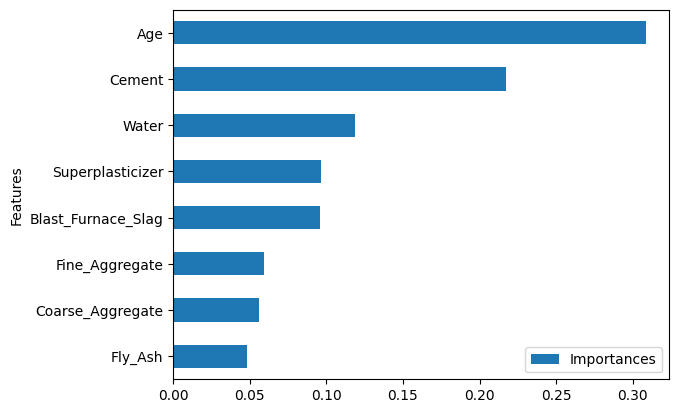

In [1144]:
#plot do gráfico de barras horizontais em ordem crescente de importância
df_importances.sort_values(by="Importances", ascending=True).plot(x="Features", y="Importances", kind="barh");

Percebe-se que a variável "Water" teve mais importância maior no treinamento do modelo RFR.

##5.3. Prevendo valores inicialmente nulos

In [1145]:
#retomando as linhas que não tinham classificação de nulos
df_to_predict

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Strength_Category
1693,359.1,560.0,0.0,249.6,0.0,1483.8,1594.5,44.8,NaN,Baixa
1761,418.8,0.0,0.0,460.8,0.0,2006.4,1375.3,6.6,NaN,Baixa
1762,663.1,0.0,0.0,460.8,0.0,1267.2,1618.0,13.3,NaN,Baixa
1823,483.2,0.0,0.0,345.1,0.0,1363.6,980.4,36.4,NaN,Baixa
1994,201.2,459.5,159.1,249.1,22.1,2279.5,1288.5,30.8,NaN,Baixa
1998,229.0,0.0,447.4,450.5,20.0,1922.0,965.9,70.0,NaN,Baixa
2011,363.5,0.0,500.9,221.9,17.9,1812.8,1042.4,50.4,NaN,Baixa
2020,334.0,195.9,194.2,435.5,32.9,2171.2,1041.9,44.8,NaN,Baixa
2025,428.2,387.1,301.6,402.7,27.0,1525.3,1439.4,47.6,NaN,Baixa


In [1146]:
#definindo features
df_to_predict_feat = df_to_predict.drop(columns=['Concrete_compressive_strength', 'Strength_Category'])

In [1147]:
#prevendo valores
y_to_predict = model_RFR.predict(df_to_predict_feat)

In [1148]:
#atribuindo valores ao dataframe
df_to_predict['Concrete_compressive_strength'] = y_to_predict
df_to_predict

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age,Concrete_compressive_strength,Strength_Category
1693,359.1,560.0,0.0,249.6,0.0,1483.8,1594.5,44.8,28.5500,Baixa
1761,418.8,0.0,0.0,460.8,0.0,2006.4,1375.3,6.6,10.3140,Baixa
1762,663.1,0.0,0.0,460.8,0.0,1267.2,1618.0,13.3,28.4470,Baixa
1823,483.2,0.0,0.0,345.1,0.0,1363.6,980.4,36.4,32.0223,Baixa
1994,201.2,459.5,159.1,249.1,22.1,2279.5,1288.5,30.8,30.3996,Baixa
1998,229.0,0.0,447.4,450.5,20.0,1922.0,965.9,70.0,21.0850,Baixa
2011,363.5,0.0,500.9,221.9,17.9,1812.8,1042.4,50.4,27.4646,Baixa
2020,334.0,195.9,194.2,435.5,32.9,2171.2,1041.9,44.8,33.6570,Baixa
2025,428.2,387.1,301.6,402.7,27.0,1525.3,1439.4,47.6,38.1740,Baixa


O valores de resistência do concreto previstos estão de acordo com a categoria que já estava definida.